In [1]:
import requests
import json
import os

import pandas as pd
from glob import glob
from tqdm import tqdm
import multiprocessing
import numpy as np

import torch
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Example classifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [2]:
import numpy as np

# Define paths to the files
pos_path = '/Users/erdem/new500_top_subreddits_unbanned_incel_users.txt'
neg_path = '/Users/erdem/new500_top_subreddits_unbanned_non_incel_users.txt'

unique_sub_reddit, map_sub_red, revmap_sub_red, user_cnt = set(), {}, {}, 0

all_data = [[], []]
incel_comments = []
non_incel_comments = []
all_data_y = []

excluded_list = ['Braincels', 'Incels', 'MGTOW', 'MensRights', 'RedPill', 'HAPAS', 'hapas', 'ForeverAlone', 'antifeminists', 'ProMaleCollective']

def read_lines(filepath, pos=True):
    global user_cnt, all_data, all_data_y, map_sub_red, unique_sub_reddit, revmap_sub_red, incel_comments, non_incel_comments
    with open(filepath, "r") as f:
        comments_list = []
        current_user = None

        for line in f:
            line = line.strip()

            if '~: ' in line:
                if comments_list and current_user:
                    if pos:
                        incel_comments.append(comments_list)
                    else:
                        non_incel_comments.append(comments_list)
                    comments_list = []

                parts = line.split('~: ', 1)
                if len(parts) == 2:
                    current_user = parts[0]
                    data = parts[1]

                    feat_array = np.zeros(13801)
                    feat_list = data.split(', ')
                    
                    for feat in feat_list:
                        try:
                            sub_red, count = feat.rsplit(" (", 1)
                            sub_red = sub_red.strip()
                            count = int(count.rstrip(")"))
                        except ValueError:
                            print(f"Problematic line in file {filepath}: {feat}")
                            continue

                        if sub_red not in map_sub_red:
                            map_sub_red[sub_red] = user_cnt
                            revmap_sub_red[user_cnt] = sub_red
                            user_cnt += 1

                        if sub_red in excluded_list:
                            count = 0

                        feat_array[map_sub_red[sub_red]] = count

                        # Add to unique_sub_reddit set
                        unique_sub_reddit.add(sub_red)

                    all_data[0].append(feat_array)
                    all_data[1].append(1 if pos else 0)

            else:
                comments_list.extend(line.split(' ||| '))

        if comments_list and current_user:
            if pos:
                incel_comments.append(comments_list)
            else:
                non_incel_comments.append(comments_list)

# Read the positive and negative user files
read_lines(pos_path, pos=True)
read_lines(neg_path, pos=False)

print(len(unique_sub_reddit), user_cnt)
print(incel_comments[:2])  # Print first 2 incel comment sets to verify
print(non_incel_comments[:2])  # Print first 2 non-incel comment sets to verify

sorted_list = sorted(unique_sub_reddit, reverse=False)
print(sorted_list[:10])


12511 12511
[['We have social unrest now. And a significant percentage of our media has dealt with space travel and aliens (good and bad) since at least the 1960s.', "That's an ankh, right?", 'OK. Why are you posting this here?', "Once in office they know what the government is going to support or change. They can benefit from this knowledge in the stock market. I'm not sure if the correct term is insider trading or something else.", '', "It's difficult to acquire millions in wealth in a few years on a $200k salary by penny pinching.", '', "And I'm sure many take bribes, the Supreme Court sure does.", '', 'This is my understanding anyway.', 'Got a brand new DVD player, when DVD players were brand new and needed something to watch. So I decided on anime, but there were no rentals yet, so I bought whatever looked interesting or was on sale. One piece was one of them.', '', "Then we had kids and I had no time for it. I'm not going to try and catch up, but the live action is good and I've 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(all_data[0], all_data[1], test_size=0.2, random_state=42)

# Split the incel and non-incel comments into train and test sets
incel_train_comments, incel_test_comments = train_test_split(incel_comments, test_size=0.2, random_state=42)
non_incel_train_comments, non_incel_test_comments = train_test_split(non_incel_comments, test_size=0.2, random_state=42)

# Train Word2Vec models on the training comments only
incel_w2v_model = Word2Vec([comment for user_comments in incel_train_comments for comment in user_comments], vector_size=100, window=5, min_count=1, workers=4)
non_incel_w2v_model = Word2Vec([comment for user_comments in non_incel_train_comments for comment in user_comments], vector_size=100, window=5, min_count=1, workers=4)

# Save models for future use
incel_w2v_model.save("incel_word2vec.model")
non_incel_w2v_model.save("non_incel_word2vec.model")

In [4]:
# Define the function to get the comment vector
def get_comment_vector(comment, model):
    words = comment.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Print lengths of data structures
print(f"Length of all_data[0] (user features): {len(all_data[0])}")
print(f"Length of all_data[1] (labels): {len(all_data[1])}")
print(f"Length of incel_comments: {len(incel_comments)}")
print(f"Length of non_incel_comments: {len(non_incel_comments)}")

# Separate indices based on labels
incel_indices = [i for i, label in enumerate(all_data[1]) if label == 1]
non_incel_indices = [i for i, label in enumerate(all_data[1]) if label == 0]

# Ensure the lengths match the number of comments
assert len(incel_indices) == len(incel_comments), "Mismatch in number of incel comments"
assert len(non_incel_indices) == len(non_incel_comments), "Mismatch in number of non-incel comments"

# Create a new list to hold combined feature vectors (original features + Word2Vec vectors)
all_data_with_comments = []

# Iterate over the feature array and corresponding comments
for i in range(len(all_data[0])):
    user_feats = all_data[0][i]
    label = all_data[1][i]
    
    if label == 1:
        comment_index = incel_indices.index(i)
        user_comments = incel_comments[comment_index]
    else:
        comment_index = non_incel_indices.index(i)
        user_comments = non_incel_comments[comment_index]
    
    # Generate comment vectors and combine with original features
    comment_vectors = [get_comment_vector(comment, incel_w2v_model if label == 1 else non_incel_w2v_model) for comment in user_comments]
    comment_vector = np.mean(comment_vectors, axis=0) if comment_vectors else np.zeros(100)
    combined_features = np.concatenate((user_feats, comment_vector))
    all_data_with_comments.append(combined_features)

# Convert the list to a numpy array
all_data_with_comments = np.array(all_data_with_comments)

print(f"Number of combined feature vectors: {len(all_data_with_comments)}")
print(f"Shape of the first combined feature vector: {all_data_with_comments[0].shape}")


Length of all_data[0] (user features): 2207
Length of all_data[1] (labels): 2207
Length of incel_comments: 1113
Length of non_incel_comments: 1094
Number of combined feature vectors: 2207
Shape of the first combined feature vector: (13901,)


In [5]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint
X_train, X_test, y_train, y_test = train_test_split(all_data_with_comments, all_data[1], test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def ML_model(model='Regression'):
    if model == 'Regression':
        model = LogisticRegression(max_iter=1000)
    elif model == 'SVM':
        model = SVC(kernel='rbf', probability=True)
    elif model == 'DecisionTree':
        model = DecisionTreeClassifier()
    elif model == 'RandomForest':
        param_dist = {
            'n_estimators': sp_randint(1, 500),
            'max_depth': sp_randint(1, 50)
        }
        model = RandomForestClassifier()
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
    elif model == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5)
    
    model.fit(X_train_scaled, y_train)
    return model


In [6]:
all_models = ['Regression', 'SVM', 'DecisionTree', 'RandomForest', 'KNN']
all_imported_models = {}

for model_name in all_models:
    model = ML_model(model=model_name)
    all_imported_models[model_name] = model
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Model: {model_name} - Accuracy: {accuracy}, F1 Score: {f1}")

    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

best_rf = all_imported_models['RandomForest'].best_estimator_

report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(report)
print(cm)

best_rf = model.best_estimator_
print('Best hyperparameters:', model.best_params_, model.best_score_)

feature_importances = best_rf.feature_importances_
print(feature_importances)

# Retrain RandomForest with best hyperparameters
model = ML_model(model="RandomForest")
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("RandomForest - Accuracy:", accuracy, f1)

report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(report)
print(cm)

best_rf = model.best_estimator_
print('Best hyperparameters:', model.best_params_, model.best_score_)

feature_importances = best_rf.feature_importances_
print(feature_importances)


Model: Regression - Accuracy: 0.9886877828054299, F1 Score: 0.9886849448327062
Model: SVM - Accuracy: 0.8167420814479638, F1 Score: 0.8116031257399953
Model: DecisionTree - Accuracy: 0.9864253393665159, F1 Score: 0.9864228374836173
Model: RandomForest - Accuracy: 0.997737556561086, F1 Score: 0.9977369889665413


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Model: KNN - Accuracy: 0.9728506787330317, F1 Score: 0.9728234136743729
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       218
           1       0.96      0.99      0.97       224

    accuracy                           0.97       442
   macro avg       0.97      0.97      0.97       442
weighted avg       0.97      0.97      0.97       442

[[208  10]
 [  2 222]]


AttributeError: 'KNeighborsClassifier' object has no attribute 'best_estimator_'

LogisticRegression(max_iter=1000)
SVC(probability=True)
DecisionTreeClassifier()
RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13317d730>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x134035bb0>},
                   random_state=42, scoring='accuracy')
KNeighborsClassifier()


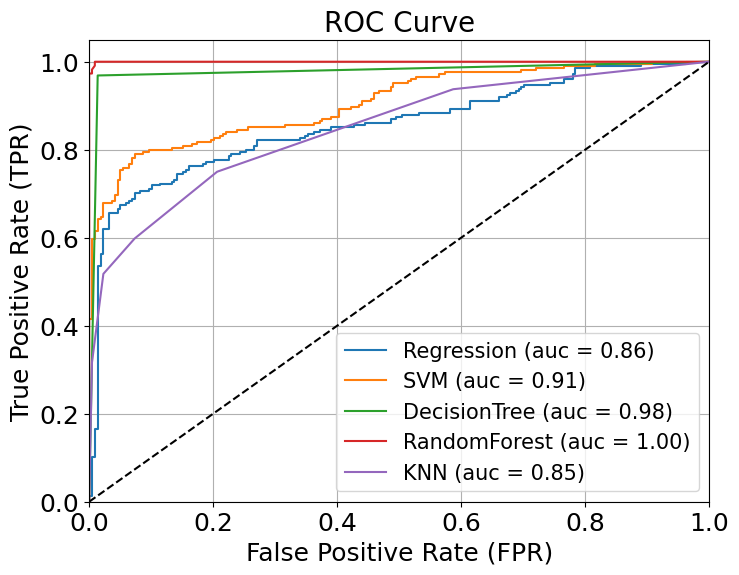

In [7]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

font_size = 18

for model_name in all_models:
    cur_model = all_imported_models[model_name]
    print(cur_model)
    
    y_proba = cur_model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])  # Assuming y_proba contains probabilities for both classes ([:, 1] selects the positive class probability)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label= model_name +' (auc = %0.2f)' % roc_auc)
    

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=font_size)
plt.ylabel('True Positive Rate (TPR)', fontsize=font_size)
plt.title('ROC Curve', fontsize=font_size+2)
plt.legend(loc="lower right", fontsize=font_size-3)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.grid(True)
dest_name = 'ROC_curve' + '.pdf'
plt.savefig(dest_name)
plt.show()

